In [1]:
try:
    import pandas as pd
except ImportError as e:
    %pip install pandas
import numpy as np
try: 
    from huggingface_hub import hf_hub_download
except ImportError as e:
    %pip install huggingface_hub
try:
    from matplotlib import pyplot as plt
except ImportError as e:
    %pip install matplotlib

This notebook demonstrates how to utilize the ARLBench Landscape data from Hugging Face to generate performance landscapes for every combination of environment and algorithm. We will then conduct a basic analysis of these landscapes.

Each landscape maps 256 distinct reinforcement learning (RL) algorithm hyperparameter configurations to their corresponding performance outcomes. This evaluation is conducted across 10 different random seeds, with performance recorded at 10 equidistant checkpoints throughout training.

First, we define the necessary values to normalize the performance of the ALE.

In [2]:
average_human = {
    "atari_battle_zone": 37187.5,
    "atari_qbert": 13455,
    "atari_phoenix": 7242.6,
    "atari_this_game": 8049,
    "atari_double_dunk": -16.4,
}
random_score = {
    "atari_battle_zone": 2360.0,
    "atari_qbert": 163.9,
    "atari_phoenix": 761.4,
    "atari_this_game": 2292.3,
    "atari_double_dunk": -18.6,
}

def ale_normalize_score(perf, env_name):
    rs = random_score[env_name]
    ah = average_human[env_name]
    return (perf - rs) / (ah - rs)

The list below can be modified to adjust which landscapes are computed. For this notebook, we have selected a small subset to maintain conciseness.

In [3]:
environment_names = [
    "atari_battle_zone", "box2d_lunar_lander", "cc_cartpole"
]
algorithm_names = ["dqn", "ppo"]
repo_id = "autorl-org/arlbench"

The function below downloads the raw landscape data from Hugging Face and organizes it by seeds and training steps. For performance evaluation, we initially select the final performance at the end of training. Later, we demonstrate how to compute alternative metrics, such as the maximum performance across all model checkpoints or the area under the learning curve.

In [4]:
def landscape_summary(env_name, algorithm, normalize_performance=False):
        hugging_face_landscape_file = f"landscapes/{env_name}_{algorithm}.csv"
        df = pd.read_csv(hf_hub_download(
            repo_id=repo_id, filename=hugging_face_landscape_file, repo_type="dataset"
        ))

        # Get all hyperparameter names and add NaN values for unset conditional hyperparameters
        hp_keys = [key for key in df.keys() if "hp_" in key]
        df[hp_keys] = df[hp_keys].fillna("NaN")

        # Set performance of crashing configurations to minimal observed performance
        df["config_id"] = df["config_id"].fillna(min(df["performance"]))

        # use the training performance at the end of training as performance
        df = df[df["training_steps"] == max(df["training_steps"])]

        # Clip lower performance due to numerical instabilities for brax and box2d
        if "brax" in env_name:  
            df["performance"] = df["performance"].clip(lower=-2000)
        elif "box2d" in env_name:
            df["performance"] = df["performance"].clip(lower=-200)

        # If required normalize the performance
        if normalize_performance:
            if not "atari" in env_name:
                max_perf, min_perf = max(df["performance"]), min(df["performance"])
                df["performance"] = df["performance"].map(lambda x: (x - min_perf) / (max_perf - min_perf))
            else:
                df["performance"] = ale_normalize_score(df["performance"], env_name)

        # Compute the mean and variance of the performance for each hyperparameter
        # configuration over all 10 seeds
        df = df.groupby(hp_keys).agg({"performance": ["mean", "var"]}).reset_index()
        df.columns = ['_'.join(col) if col[1] else col[0] for col in df.columns.to_flat_index()]

        # Check that we obtain the expected number of configurations after grouping
        assert len(df) == 256, f"Configurations appear missing from landscape data. " \
                               f"Expected 256 configurations but observed {len(df)}"

        return df


We now compute the non-normalized landscape for the selected environment and algorithm combinations. Set `normalize_performance` to examine the normalized values.

In [5]:
landscapes = {}
for algo in algorithm_names:
    for env in environment_names:
        landscapes[(env, algo)] = landscape_summary(env, algo, normalize_performance=False)

First, we analyze the resulting landscapes by identifying the best configuration for each environment-algorithm combination. We then print the corresponding best performance and its variance.

In [6]:
for algo in algorithm_names:
    for env in environment_names:
        df = landscapes[(env, algo)]
        max_idx = df["performance_mean"].idxmax()
        max_perf = df.loc[max_idx]["performance_mean"]
        var = df.loc[max_idx]["performance_var"]
        print(
            f"Best performance for {algo} on {env} is {round(max_perf, 2)} +- {round(np.sqrt(var), 2)} " \
            f"with best configuration: \n"
        )
        print(df.loc[max_idx])
        print("\n\n")

Best performance for dqn on atari_battle_zone is 23073.44 +- 4926.62 with best configuration: 

hp_config.buffer_batch_size                     16
hp_config.buffer_prio_sampling               False
hp_config.buffer_size                       582748
hp_config.initial_epsilon                 0.553736
hp_config.learning_rate                   0.000027
hp_config.learning_starts                    15522
hp_config.target_epsilon                  0.005169
hp_config.use_target_network                  True
hp_config.buffer_alpha                         NaN
hp_config.buffer_beta                          NaN
hp_config.buffer_epsilon                       NaN
hp_config.target_update_interval            1507.0
performance_mean                       23073.43735
performance_var                     24271596.43941
Name: 24, dtype: object



Best performance for dqn on box2d_lunar_lander is 98.64 +- 72.33 with best configuration: 

hp_config.buffer_batch_size                 256
hp_config.buffer_prio_s

Next, let’s compute simple histograms to visualize the performance distribution across all 256 tested configurations.

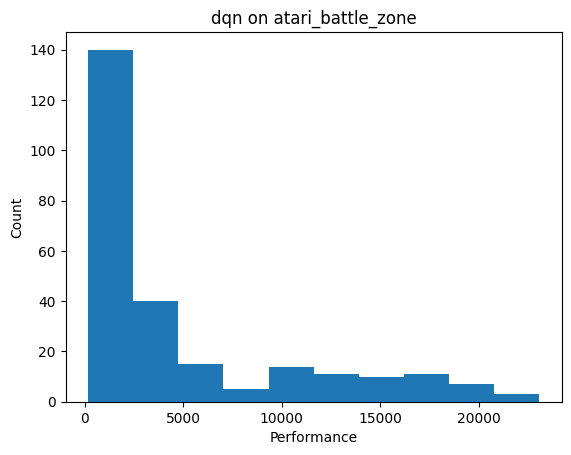

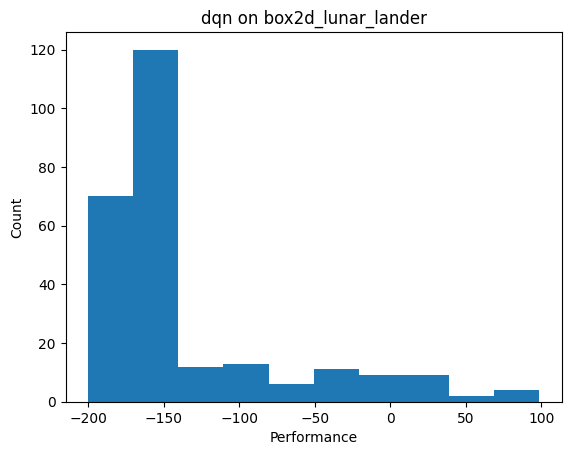

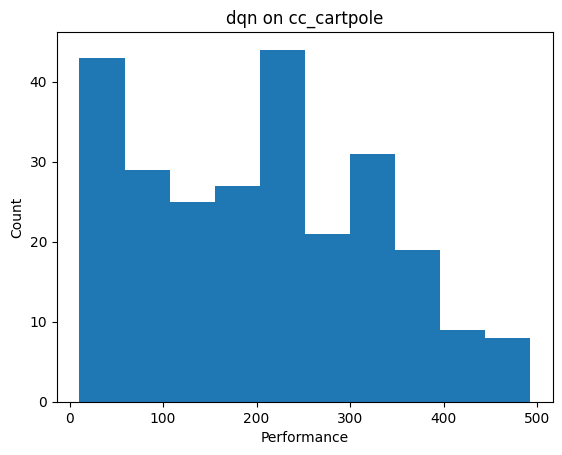

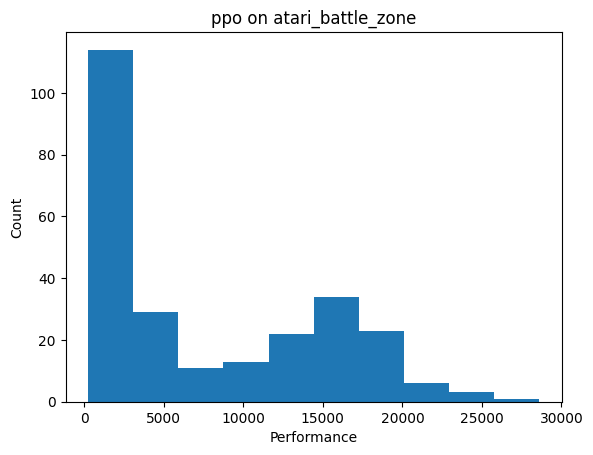

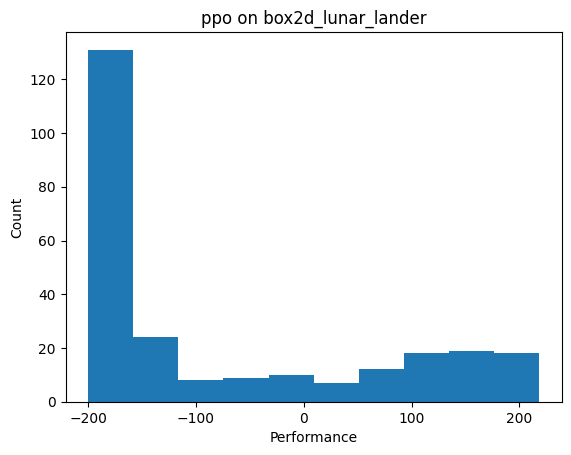

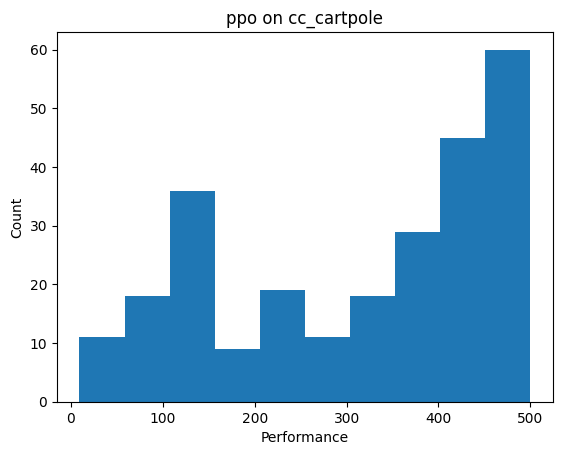

In [7]:
for algo in algorithm_names:
    for env in environment_names:
        df = landscapes[(env, algo)]
        plt.hist(df["performance_mean"])
        plt.title(f"{algo} on {env}")
        plt.xlabel("Performance")
        plt.ylabel("Count")
        plt.show()

To leverage the recorded RL learning curves, the following extended landscape summary function also computes the maximum performance during training and the area under the learning curve.

In [8]:
def landscape_summary_extended(env_name, algorithm, normalize_performance=False):
    hugging_face_landscape_file = f"landscapes/{env_name}_{algorithm}.csv"
    df = pd.read_csv(hf_hub_download(
        repo_id=repo_id, filename=hugging_face_landscape_file, repo_type="dataset"
    ))
    
    hp_keys = [key for key in df.columns if "hp_" in key]
    df[hp_keys] = df[hp_keys].fillna("NaN")
    df["config_id"] = df["config_id"].fillna(min(df["performance"]))
    df = df.groupby(hp_keys + ["training_steps"], as_index=False).agg({"performance": "mean",
                                                                 "config_id": "first"})

    # obtain final performance, max performance over training and area under the curve
    last_df = df[df["training_steps"] == max(df["training_steps"])]
    max_df = df.groupby(hp_keys).agg({"performance": "max", "config_id": "first"})
    auc_df = df.groupby(hp_keys).agg({"performance": "mean", "config_id": "first"})
    
    df = last_df.rename(columns={"performance": "last_performance"})
    max_df = max_df.rename(columns={"performance": "max_performance"})
    auc_df = auc_df.rename(columns={"performance": "auc_performance"})
    df = df.merge(max_df, on="config_id", how="left")
    df = df.merge(auc_df, on="config_id", how="left")
    df = df[["config_id"] + [col for col in df.columns if col != "config_id"]]
    df = df.drop("training_steps", axis=1)

    if normalize_performance:
        for perf_key in ["last_performance", "max_performance", "auc_performance"]:
            if "brax" in env_name or "box2d" in env_name:  # clip lower performance due to numerical instabilities
                df[perf_key] = df[perf_key].clip(lower=-2000)
            if not "atari" in env_name:
                max_perf = max(df[perf_key])
                min_perf = min(df[perf_key])
                df[perf_key] = df[perf_key].map(lambda x: (x - min_perf) / (max_perf - min_perf))
            else:
                df[perf_key] = ale_normalize_score(df[perf_key], env_name)

    return df

Finally, let’s compare the best achieved values across the three different performance metrics.

In [9]:
for algo in algorithm_names:
    for env in environment_names:
        df = landscape_summary_extended(env, algo, normalize_performance=False)
        for perf_key in ["last_performance", "max_performance", "auc_performance"]: 
            max_idx = df[perf_key].idxmax()
            max_perf = df.loc[max_idx][perf_key]
            print(f"Best {perf_key} for {algo} on {env} is {round(max_perf, 2)} for config id {max_idx}")
        print("\n")

Best last_performance for dqn on atari_battle_zone is 23073.44 for config id 24
Best max_performance for dqn on atari_battle_zone is 23488.28 for config id 24
Best auc_performance for dqn on atari_battle_zone is 16799.61 for config id 24


Best last_performance for dqn on box2d_lunar_lander is 98.64 for config id 188
Best max_performance for dqn on box2d_lunar_lander is 141.15 for config id 183
Best auc_performance for dqn on box2d_lunar_lander is 19.56 for config id 183


Best last_performance for dqn on cc_cartpole is 492.66 for config id 219
Best max_performance for dqn on cc_cartpole is 500.0 for config id 219
Best auc_performance for dqn on cc_cartpole is 384.55 for config id 219


Best last_performance for ppo on atari_battle_zone is 28593.75 for config id 27
Best max_performance for ppo on atari_battle_zone is 28593.75 for config id 27
Best auc_performance for ppo on atari_battle_zone is 19731.88 for config id 4


Best last_performance for ppo on box2d_lunar_lander is 218.34 for